In [1]:
# processing
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 12})

from matplotlib import font_manager
font_manager.fontManager.addfont('../../misc/lucida-sans-unicode.ttf')

import seaborn as sns
tregs.mpl_pboc.plotting_style()

{'green': '#7AA974',
 'light_green': '#BFD598',
 'pale_green': '#DCECCB',
 'yellow': '#EAC264',
 'light_yellow': '#F3DAA9',
 'pale_yellow': '#FFEDCE',
 'blue': '#738FC1',
 'light_blue': '#A9BFE3',
 'pale_blue': '#C9D7EE',
 'red': '#D56C55',
 'light_red': '#E8B19D',
 'pale_red': '#F1D4C9',
 'purple': '#AB85AC',
 'light_purple': '#D4C2D9',
 'dark_green': '#7E9D90',
 'dark_brown': '#905426'}

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

### Simple repression

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

In [6]:
def plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound,
                   outfile=None):
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6))
    exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                        smoothed=True, windowsize=3)
    
    fig, ax = plt.subplots(figsize=(12,2.5))

    ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
    ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')
    ax.axvspan(2, 2 + 17, alpha=0.7, color='#E8B19D')

    ax.set_ylim(top=max(footprint)*1.15)
    ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                            8,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                            10,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')
    
    ax.add_patch(mpl.patches.Rectangle((2, max(footprint)*1.15),
                                        17,
                                        max(footprint) * 0.2,
                                        facecolor='#D56C55',
                                        clip_on=False,
                                        linewidth = 0))
    ax.text(2 + 0.5 * 17, max(footprint) * 1.2, 'LacI', fontsize = 10, color = 'k',
                ha='center', va='baseline')


    windowsize=3
    cut = int((windowsize - 1) / 2)
    x = np.arange(-115 + cut, 45 - cut)
    shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
    ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
    ax.set_ylabel('Information (bits)', fontsize=12)

    custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                    Line2D([0], [0], color='#738FC1', lw=4)]
    plt.legend(custom_lines,
            ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
            bbox_to_anchor=(1.2, 0.95), frameon=False)

    plt.tight_layout()
    if outfile is not None:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()

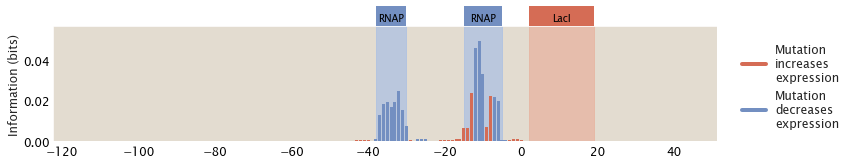

In [7]:
n_NS = len(genome)
n_p = 4600
n_r = 0

ep_wt = -5
er_wt = -15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']
nbins = 2
upper_bound = np.mean(mu_data)
plot_footprint(promoter, mut_list, mu_data, nbins, upper_bound,
                outfile='../../figs/simrep_knockout.png')

### Double repression

In [8]:
def doublerep_pbound(p_seq, r1_seq, r2_seq,
                  p_emat, r1_emat, r2_emat, 
                  n_p, n_r1, n_r2, n_NS,
                  ep_wt=0, er1_wt=0, er2_wt=0, e_int=0,
                  gate='AND'):

    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_r1 = tregs.simulate.get_weight(r1_seq, r1_emat, e_wt=er1_wt)
    w_r2 = tregs.simulate.get_weight(r2_seq, r2_emat, e_wt=er2_wt)
    if gate == 'AND':
        z = 1 + n_p / n_NS * w_p + n_r1 / n_NS * w_r1 + n_r2 / n_NS * w_r2
        z += (n_r1 / n_NS * w_r1) * (n_r2 / n_NS * w_r2) * np.exp(-e_int)
        pbound = (n_p / n_NS * w_p) / z
    if gate == 'OR':
        z = 1 + n_p / n_NS * w_p + n_r1 / n_NS * w_r1 + n_r2 / n_NS * w_r2
        z += (n_p / n_NS * w_p) * (n_r1 / n_NS * w_r1)
        z += (n_p / n_NS * w_p) * (n_r2 / n_NS * w_r2)
        z += (n_r1 / n_NS * w_r1) * (n_r2 / n_NS * w_r2) * np.exp(-e_int)
        pbound = (n_p / n_NS * w_p + (n_p / n_NS * w_p) * (n_r1 / n_NS * w_r1) + (n_p / n_NS * w_p) * (n_r2 / n_NS * w_r2)) / z

    return pbound

In [9]:
def doublerep_helper(mutants, rnap_start, rnap_end, rep1_start, rep1_end, rep2_start, rep2_end,
                  p_emat, r1_emat, r2_emat, n_p, n_r1, n_r2, n_NS, gate,
                  ep_wt=0, er1_wt=0, er2_wt=0, e_int=0):

    l_tr = []
    for mut in mutants:
        rv = {}
        rv['seq'] = mut
        rnap_mut = mut[rnap_start:rnap_end].upper()
        rep1_mut = mut[rep1_start:rep1_end].upper()
        rep2_mut = mut[rep2_start:rep2_end].upper()
        rv['pbound'] = doublerep_pbound(rnap_mut, rep1_mut, rep2_mut,
                                        p_emat, r1_emat, r2_emat, 
                                        n_p, n_r1, n_r2, n_NS,
                                        ep_wt=ep_wt, er1_wt=er1_wt, er2_wt=er2_wt, e_int=e_int,
                                        gate=gate)
        l_tr.append(rv)
    df_simrep = pd.DataFrame.from_records(l_tr)

    return df_simrep


def doublerep(wtseq, rnap_wtseq, rep1_wtseq, rep2_wtseq, p_emat, r1_emat, r2_emat, 
           ep_wt, er1_wt, er2_wt, e_int, n_NS, n_p, n_r1, n_r2, gate,
           num_mutants=10000, mutrate=0.1, scaling_factor=100):
    
    mutants = np.unique(tregs.wgregseq.mutations_rand(wtseq,
                                       rate=mutrate,
                                       num_mutants=num_mutants,
                                       number_fixed=True))

    rnap_start, rnap_end = tregs.seq_utils.find_binding_site(wtseq, rnap_wtseq)
    rep1_start, rep1_end = tregs.seq_utils.find_binding_site(wtseq, rep1_wtseq)
    rep2_start, rep2_end = tregs.seq_utils.find_binding_site(wtseq, rep2_wtseq)

    df_simrep = doublerep_helper(mutants, rnap_start, rnap_end, rep1_start, rep1_end, rep2_start, rep2_end,
                              p_emat, r1_emat, r2_emat, n_p, n_r1, n_r2, n_NS,
                              ep_wt=ep_wt, er1_wt=er1_wt, er2_wt=er2_wt, e_int=e_int, gate=gate)
    
    dna_cnt = tregs.simulate.get_dna_cnt(len(df_simrep))
    df_simrep['ct_0'] = dna_cnt
    df_simrep = df_simrep[df_simrep.ct_0 != 0.0]

    df_simrep['ct_1'] = 0.1 + df_simrep['ct_0'] * df_simrep['pbound'] * scaling_factor
    df_simrep['ct_1'] = df_simrep['ct_1'].astype(int)
    df_simrep['ct'] = df_simrep['ct_0'] + df_simrep['ct_1']

    df_simrep['ct'] = df_simrep['ct'].astype(float)
    df_simrep['ct_0'] = df_simrep['ct_0'].astype(float)
    df_simrep['ct_1'] = df_simrep['ct_1'].astype(float)
    df_simrep['norm_ct_1'] = df_simrep['ct_1'] / df_simrep['ct_0']

    return df_simrep

In [10]:
def generate_emap(seq, fixed=False,
                  fixed_value=1,
                  max_mut_energy=0.5):
    nt_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    emat = np.zeros((4, len(seq)))
    for i,nt in enumerate(seq):
        for j in range(4):
            if j != nt_index[nt]:
                if fixed:
                    emat[j, i] = fixed_value
                else:
                    emat[j, i] = np.random.uniform(low=0.1, high=max_mut_energy)
    
    return emat

In [11]:
def plot_footprint(df, rep1_start_site, rep2_start_site,
                   outfile=None):
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']

    nbins = 2
    upper_bound = max(np.mean(mu_data), 1)
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=0)
    exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                        smoothed=True, windowsize=3)

    fig, ax = plt.subplots(figsize=(12,2.5))

    ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
    ax.axvspan(rep1_start_site, rep1_start_site + 10, alpha=0.7, color='#E8B19D')
    ax.axvspan(rep2_start_site, rep2_start_site + 10, alpha=0.7, color='#E8B19D')
    ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')


    ax.set_ylim(top=max(footprint)*1.15)
    ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                            8,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                            10,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((rep1_start_site, max(footprint)*1.15),
                                            10,
                                            max(footprint) * 0.2,
                                            facecolor='#D56C55',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(rep1_start_site + 0.5 * 10, max(footprint) * 1.2, 'R1', fontsize = 10, color = 'k',
            ha='center', va='baseline')
    
    ax.add_patch(mpl.patches.Rectangle((rep2_start_site, max(footprint)*1.15),
                                            10,
                                            max(footprint) * 0.2,
                                            facecolor='#D56C55',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(rep2_start_site + 0.5 * 10, max(footprint) * 1.2, 'R2', fontsize = 10, color = 'k',
            ha='center', va='baseline')


    windowsize=3
    cut = int((windowsize - 1) / 2)
    x = np.arange(-115 + cut, 45 - cut)
    shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
    ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
    ax.set_ylabel('Information (bits)', fontsize=12)

    custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                    Line2D([0], [0], color='#738FC1', lw=4)]
    plt.legend(custom_lines,
            ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
            bbox_to_anchor=(1.2, 0.95), frameon=False)

    plt.tight_layout()
    if outfile is not None:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()

In [12]:
rep1_site = promoter[(115-70):(115-60)]
rep2_site = promoter[(115-50):(115-40)]
r1_emat = generate_emap(rep1_site, fixed=True, fixed_value=1)
r2_emat = generate_emap(rep2_site, fixed=True, fixed_value=1)

changing the relative binding energies/copy numbers

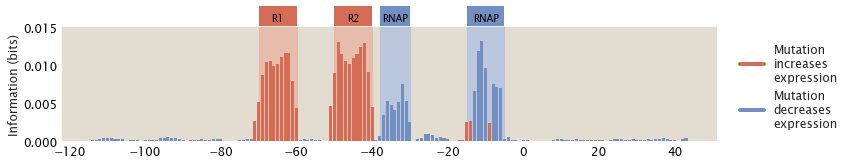

In [22]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -15, -15
e_int = -2
n_p, n_r1, n_r2 = 4600, 15, 15

df = doublerep(promoter, rnap_site, rep1_site, rep2_site, rnap_emat, r1_emat, r2_emat, 
            ep_wt, er1_wt, er2_wt, e_int, n_NS, n_p, n_r1, n_r2, 'AND', scaling_factor=10**6)
plot_footprint(df, -70, -50,
               outfile='../../figs/2_0_knockout_control.png')

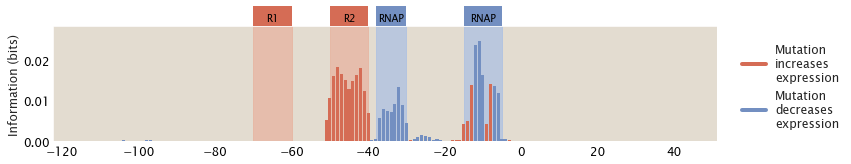

In [13]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -15, -15
e_int = -10
n_p, n_r1, n_r2 = 4600, 0, 15

df = doublerep(promoter, rnap_site, rep1_site, rep2_site, rnap_emat, r1_emat, r2_emat, 
            ep_wt, er1_wt, er2_wt, e_int, n_NS, n_p, n_r1, n_r2, 'AND', scaling_factor=10**6)
plot_footprint(df, -70, -50,
               outfile='../../figs/2_0_knockout_AND1.png')

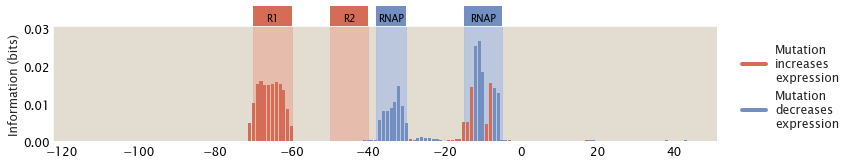

In [16]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -15, -15
e_int = -10
n_p, n_r1, n_r2 = 4600, 15, 0

df = doublerep(promoter, rnap_site, rep1_site, rep2_site, rnap_emat, r1_emat, r2_emat, 
            ep_wt, er1_wt, er2_wt, e_int, n_NS, n_p, n_r1, n_r2, 'AND', scaling_factor=10**6)
plot_footprint(df, -70, -50,
               outfile='../../figs/2_0_knockout_AND2.png')

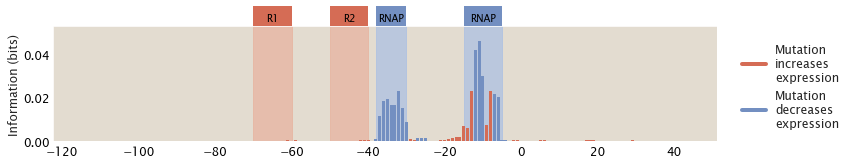

In [17]:
n_NS = len(genome)
ep_wt, er1_wt, er2_wt = -5, -15, -15
e_int = -10
n_p, n_r1, n_r2 = 4600, 0, 15

df = doublerep(promoter, rnap_site, rep1_site, rep2_site, rnap_emat, r1_emat, r2_emat, 
            ep_wt, er1_wt, er2_wt, e_int, n_NS, n_p, n_r1, n_r2, 'OR', scaling_factor=10**6)
plot_footprint(df, -70, -50,
               outfile='../../figs/2_0_knockout_OR.png')

### Double activation

In [5]:
def doubleact_pbound(p_seq, a1_seq, a2_seq,
                     p_emat, a1_emat, a2_emat, 
                     n_p, n_a1, n_a2, n_NS,
                     ep_wt=0, ea1_wt=0, ea2_wt=0,
                     e_int_pa1=0, e_int_pa2=0, e_int_a1a2=0,
                     gate='AND'):

    w_p = tregs.simulate.get_weight(p_seq, p_emat, e_wt=ep_wt)
    w_a1 = tregs.simulate.get_weight(a1_seq, a1_emat, e_wt=ea1_wt)
    w_a2 = tregs.simulate.get_weight(a2_seq, a2_emat, e_wt=ea2_wt)

    if gate == 'AND':
        z = np.zeros(8)
        z[0] = 1
        z[1] = n_a1 / n_NS * w_a1
        z[2] = n_a2 / n_NS * w_a2
        z[3] = (n_a1 / n_NS * w_a1) * (n_a2 / n_NS * w_a2)
        z[4] = n_p / n_NS * w_p
        z[5] = (n_p / n_NS * w_p) * (n_a1 / n_NS * w_a1) * np.exp(-e_int_pa1)
        z[6] = (n_p / n_NS * w_p) * (n_a2 / n_NS * w_a2) * np.exp(-e_int_pa2)
        z[7] = (n_p / n_NS * w_p) * (n_a1 / n_NS * w_a1) * (n_a2 / n_NS * w_a2) * np.exp(-e_int_pa1) * np.exp(-e_int_pa2) * np.exp(-e_int_a1a2)

        pbound = np.sum(z[4:]) / np.sum(z)

    elif gate == 'OR':

        z = np.zeros(8)
        z[0] = 1
        z[1] = n_a1 / n_NS * w_a1
        z[2] = n_a2 / n_NS * w_a2
        z[3] = (n_a1 / n_NS * w_a1) * (n_a2 / n_NS * w_a2)
        z[4] = n_p / n_NS * w_p
        z[5] = (n_p / n_NS * w_p) * (n_a1 / n_NS * w_a1) * np.exp(-e_int_pa1)
        z[6] = (n_p / n_NS * w_p) * (n_a2 / n_NS * w_a2) * np.exp(-e_int_pa2)
        z[7] = (n_p / n_NS * w_p) * (n_a1 / n_NS * w_a1) * (n_a2 / n_NS * w_a2) * np.exp(-e_int_pa1) * np.exp(-e_int_pa2)

        pbound = np.sum(z[4:]) / np.sum(z)

    return pbound

In [6]:
def doubleact_helper(mutants, rnap_start, rnap_end, act1_start, act1_end, act2_start, act2_end,
                  p_emat, a1_emat, a2_emat, n_p, n_a1, n_a2, n_NS, gate,
                  ep_wt=0, ea1_wt=0, ea2_wt=0,
                  e_int_pa1=0, e_int_pa2=0, e_int_a1a2=0):

    l_tr = []
    for mut in mutants:
        rv = {}
        rv['seq'] = mut
        rnap_mut = mut[rnap_start:rnap_end].upper()
        act1_mut = mut[act1_start:act1_end].upper()
        act2_mut = mut[act2_start:act2_end].upper()
        rv['pbound'] = doubleact_pbound(rnap_mut, act1_mut, act2_mut,
                                        p_emat, a1_emat, a2_emat, 
                                        n_p, n_a1, n_a2, n_NS,
                                        ep_wt=ep_wt, ea1_wt=ea1_wt, ea2_wt=ea2_wt,
                                        e_int_pa1=e_int_pa1, e_int_pa2=e_int_pa2, e_int_a1a2=e_int_a1a2,
                                        gate=gate)
        l_tr.append(rv)
    df_simact = pd.DataFrame.from_records(l_tr)

    return df_simact


def doubleact(wtseq, rnap_wtseq, act1_wtseq, act2_wtseq, p_emat, a1_emat, a2_emat, 
           ep_wt, ea1_wt, ea2_wt,
           e_int_pa1, e_int_pa2, e_int_a1a2,
           n_NS, n_p, n_a1, n_a2, gate,
           num_mutants=10000, mutrate=0.1, scaling_factor=100):
    
    mutants = np.unique(tregs.wgregseq.mutations_rand(wtseq,
                                       rate=mutrate,
                                       num_mutants=num_mutants,
                                       number_fixed=True))

    rnap_start, rnap_end = tregs.seq_utils.find_binding_site(wtseq, rnap_wtseq)
    act1_start, act1_end = tregs.seq_utils.find_binding_site(wtseq, act1_wtseq)
    act2_start, act2_end = tregs.seq_utils.find_binding_site(wtseq, act2_wtseq)

    df_simact = doubleact_helper(mutants, rnap_start, rnap_end, act1_start, act1_end, act2_start, act2_end,
                                 p_emat, a1_emat, a2_emat, n_p, n_a1, n_a2, n_NS,
                                 ep_wt=ep_wt, ea1_wt=ea1_wt, ea2_wt=ea2_wt,
                                 e_int_pa1=e_int_pa1, e_int_pa2=e_int_pa2, e_int_a1a2=e_int_a1a2,
                                 gate=gate)
    
    dna_cnt = tregs.simulate.get_dna_cnt(len(df_simact))
    df_simact['ct_0'] = dna_cnt
    df_simact = df_simact[df_simact.ct_0 != 0.0]

    df_simact['ct_1'] = 0.1 + df_simact['ct_0'] * df_simact['pbound'] * scaling_factor
    df_simact['ct_1'] = df_simact['ct_1'].astype(int)
    df_simact['ct'] = df_simact['ct_0'] + df_simact['ct_1']

    df_simact['ct'] = df_simact['ct'].astype(float)
    df_simact['ct_0'] = df_simact['ct_0'].astype(float)
    df_simact['ct_1'] = df_simact['ct_1'].astype(float)
    df_simact['norm_ct_1'] = df_simact['ct_1'] / df_simact['ct_0']

    return df_simact

In [7]:
def generate_emap(seq, fixed=False,
                  fixed_value=1,
                  max_mut_energy=0.5):
    nt_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    emat = np.zeros((4, len(seq)))
    for i,nt in enumerate(seq):
        for j in range(4):
            if j != nt_index[nt]:
                if fixed:
                    emat[j, i] = fixed_value
                else:
                    emat[j, i] = np.random.uniform(low=0.1, high=max_mut_energy)
    
    return emat

In [8]:
def plot_footprint(df, act1_start_site, act2_start_site,
                   outfile=None):
    mut_list = df['seq'].values
    mu_data = df['norm_ct_1']

    nbins = 2
    upper_bound = max(np.mean(mu_data), 1)
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=10**(-6))
    exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                        smoothed=True, windowsize=3)

    fig, ax = plt.subplots(figsize=(12,2.5))

    ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
    ax.axvspan(act1_start_site, act1_start_site + 10, alpha=0.7, color='#DCECCB')
    ax.axvspan(act2_start_site, act2_start_site + 10, alpha=0.7, color='#DCECCB')
    ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')


    ax.set_ylim(top=max(footprint)*1.15)
    ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                            8,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                            10,
                                            max(footprint) * 0.2,
                                            facecolor='#738FC1',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
            ha='center', va='baseline')

    ax.add_patch(mpl.patches.Rectangle((act1_start_site, max(footprint)*1.15),
                                            10,
                                            max(footprint) * 0.2,
                                            facecolor='#7AA974',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(act1_start_site + 0.5 * 10, max(footprint) * 1.2, 'A1', fontsize = 10, color = 'k',
            ha='center', va='baseline')
    
    ax.add_patch(mpl.patches.Rectangle((act2_start_site, max(footprint)*1.15),
                                            10,
                                            max(footprint) * 0.2,
                                            facecolor='#7AA974',
                                            clip_on=False,
                                            linewidth = 0))
    ax.text(act2_start_site + 0.5 * 10, max(footprint) * 1.2, 'A2', fontsize = 10, color = 'k',
            ha='center', va='baseline')


    windowsize=3
    cut = int((windowsize - 1) / 2)
    x = np.arange(-115 + cut, 45 - cut)
    shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
    ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
    ax.set_ylabel('Information (bits)', fontsize=12)

    custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                    Line2D([0], [0], color='#738FC1', lw=4)]
    plt.legend(custom_lines,
            ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
            bbox_to_anchor=(1.2, 0.95), frameon=False)

    plt.tight_layout()
    if outfile is not None:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()

In [9]:
act1_site = promoter[(115 - 110 + 15):(115 - 110 + 25)]
act2_site = promoter[(115 - 110 + 35):(115 - 110 + 45)]
a1_emat = generate_emap(act1_site, fixed=True, fixed_value=1)
a2_emat = generate_emap(act2_site, fixed=True, fixed_value=1)

In [26]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -5, -5, -5
n_p, n_a1, n_a2 = 4600, 50, 50

df = doubleact(promoter, rnap_site, act1_site, act2_site, rnap_emat, a1_emat, a2_emat, 
               ep_wt, ea1_wt, ea2_wt, e_int_pa1, e_int_pa2, e_int_a1a2, n_NS, n_p, n_a1, n_a2, 'AND', scaling_factor=100)

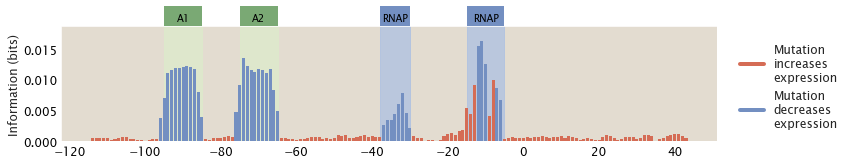

In [27]:
plot_footprint(df, -110+15, -110+35,
               outfile='../../figs/0_2_knockout_control.png')

In [28]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -5, -5, -5
n_p, n_a1, n_a2 = 4600, 0, 50

df = doubleact(promoter, rnap_site, act1_site, act2_site, rnap_emat, a1_emat, a2_emat, 
               ep_wt, ea1_wt, ea2_wt, e_int_pa1, e_int_pa2, e_int_a1a2, n_NS, n_p, n_a1, n_a2, 'AND', scaling_factor=100)

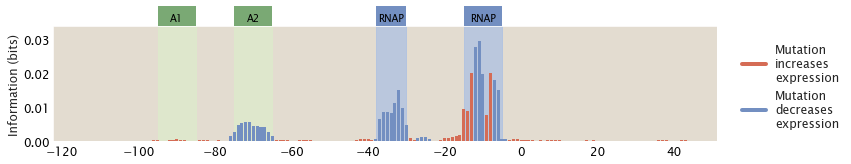

In [29]:
plot_footprint(df, -110+15, -110+35,
               outfile='../../figs/0_2_knockout_AND1.png')

In [30]:
n_NS = len(genome)
ep_wt, ea1_wt, ea2_wt = -2, -7, -7
e_int_pa1, e_int_pa2, e_int_a1a2 = -7, -7, -7
n_p, n_a1, n_a2 = 4600, 0, 50

df = doubleact(promoter, rnap_site, act1_site, act2_site, rnap_emat, a1_emat, a2_emat, 
               ep_wt, ea1_wt, ea2_wt, e_int_pa1, e_int_pa2, e_int_a1a2, n_NS, n_p, n_a1, n_a2, 'OR', scaling_factor=100)

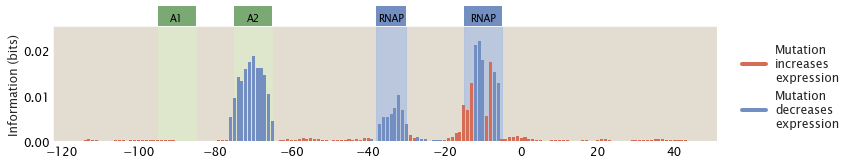

In [31]:
plot_footprint(df, -110+15, -110+35,
               outfile='../../figs/0_2_knockout_OR.png')